In [4]:
# Import dependencies
import torch
import torchaudio
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import cv2
import os

from tqdm import tqdm

## Checking your GPU 

If you are using Google Colab, you can check which GPU you have been assigned by running the following cell. Otherwise, if you are running on your local machine, you can check the GPU model that you are using.

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU :D')
else:
    device = torch.device('cpu')
    print('Using CPU D:')

Using GPU :D


## Loading dataset 

We will use mini speech commands dataset which contains 8 different classes. You can read more about the dataset [Speech Commands Dataset](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html).

In [7]:
import requests
import zipfile

# Dataset Directory
dataset_dir = '../data'
os.makedirs(dataset_dir, exist_ok=True)

# URL to download the dataset
url = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"

# Download the dataset
zip_path = os.path.join(dataset_dir, "mini_speech_commands.zip")

In [9]:
if not os.path.exists(zip_path):
    print("Loading mini_speech_commands...")
    response = requests.get(url)
    with open(zip_path, 'wb') as f:
        f.write(response.content)

# Decompress the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

print("Download and extraction complete")

Download and extraction complete


In [10]:
import os
from torch.utils.data import Dataset

class MiniSpeechCommandsDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.audio_files = []
        for label in self.classes:
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.wav')]
                self.audio_files.extend([(file, label) for file in files])

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path, label = self.audio_files[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        label_idx = self.classes.index(label)
        return waveform, sample_rate, label_idx


In [11]:
dataset_dir = '../data/mini_speech_commands'
mini_speech_commands = MiniSpeechCommandsDataset(dataset_dir)
waveform, sample_rate, label = mini_speech_commands[0]
print(f"Shape waveform: {waveform.shape}, Sample rate: {sample_rate}, Label: {label}")

Shape waveform: torch.Size([1, 16000]), Sample rate: 16000, Label: 1


In [14]:
np.random.seed(42)
total_size = len(mini_speech_commands)
random_idxs = np.random.randint(0, total_size, 100)
classes = mini_speech_commands.classes
samples = []
for idx in random_idxs:
    waveform, sample_rate, label = mini_speech_commands[idx]
    samples.append((waveform, sample_rate, classes[label]))

In [15]:
samples_go = [sample for sample in samples if sample[2] == 'go']
samples_stop = [sample for sample in samples if sample[2] == 'stop']
samples_yes = [sample for sample in samples if sample[2] == 'yes']

len(samples_go), len(samples_stop), len(samples_yes)

(13, 12, 16)

In [16]:
samples_go_stft = []
samples_stop_stft = []
samples_yes_stft = []
n_fft = 400
hop_length = 160
win_length = 400

for waveform, sample_rate, label in samples_go[:5]:
    stft = torch.stft(waveform, n_fft=n_fft, hop_length=hop_length, win_length=win_length, return_complex=True)
    spectrogram = torch.abs(stft)
    spectrogram_db = 20 * torch.log10(spectrogram + 1e-6)
    samples_go_stft.append(spectrogram_db)

for waveform, sample_rate, label in samples_stop[:5]:
    stft = torch.stft(waveform, n_fft=n_fft, hop_length=hop_length, win_length=win_length, return_complex=True)
    spectrogram = torch.abs(stft)
    spectrogram_db = 20 * torch.log10(spectrogram + 1e-6)
    samples_stop_stft.append(spectrogram_db)

for waveform, sample_rate, label in samples_yes[:5]:
    stft = torch.stft(waveform, n_fft=n_fft, hop_length=hop_length, win_length=win_length, return_complex=True)
    spectrogram = torch.abs(stft)
    spectrogram_db = 20 * torch.log10(spectrogram + 1e-6)
    samples_yes_stft.append(spectrogram_db)

c:\Users\gabri\anaconda3\envs\dl\lib\site-packages\torch\functional.py:704: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\SpectralOps.cpp:842.)
  return _VF.stft(  # type: ignore[attr-defined]


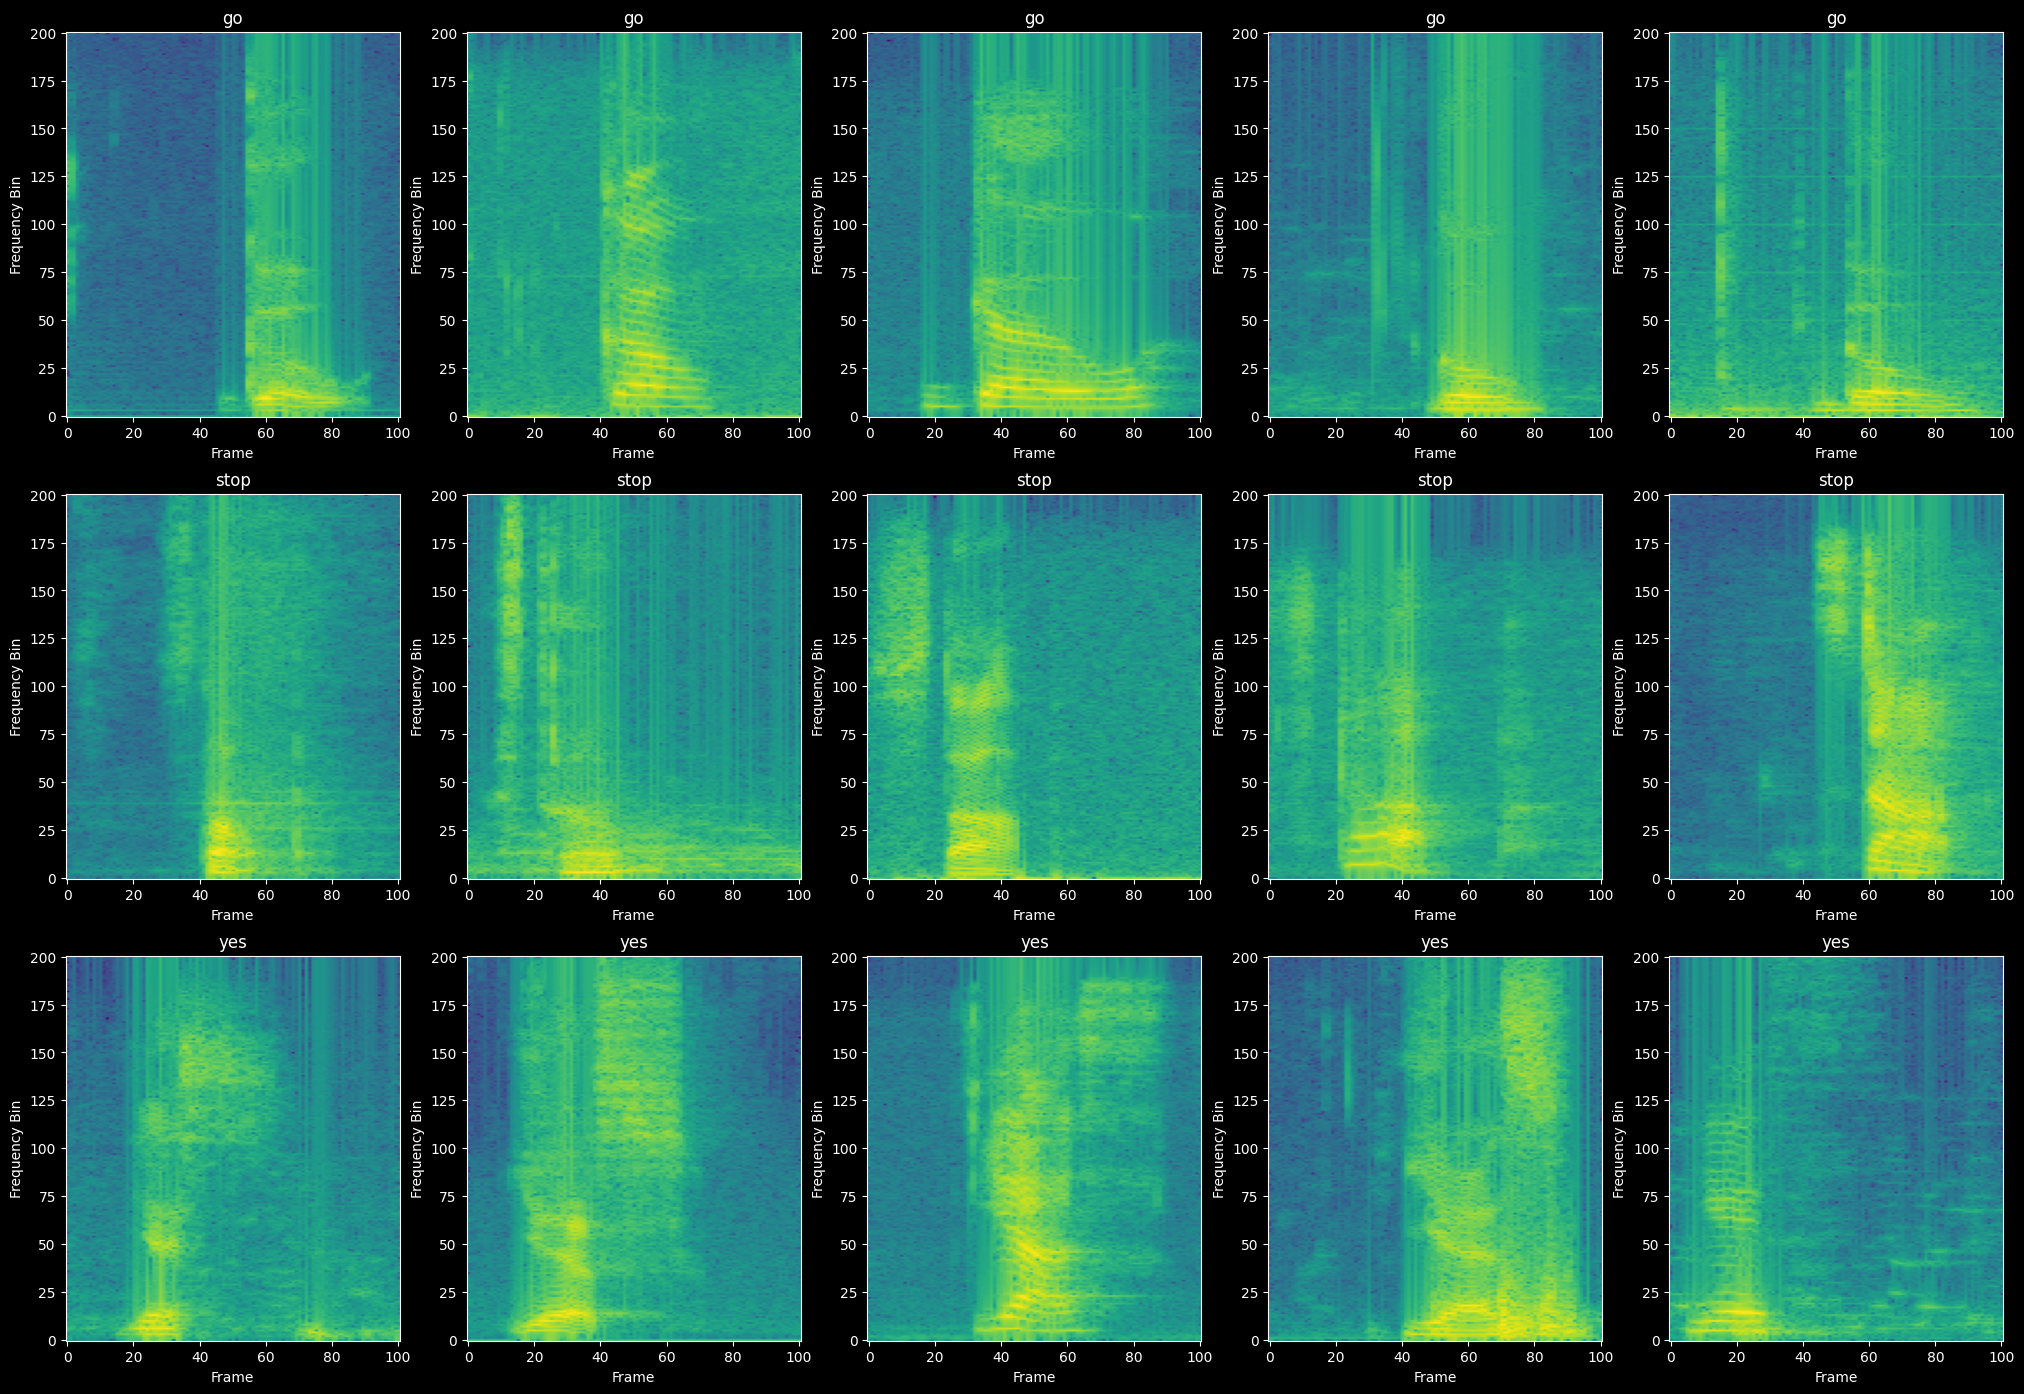

In [17]:
dark_mode = True

if dark_mode:
    plt.style.use('dark_background')
    plt.rcParams['axes.facecolor'] = '#26262e' 
else:
    plt.style.use('default')
            
fig, axs = plt.subplots(3, 5, figsize=(25, 17))

for i, sample in enumerate(samples_go_stft):
    axs[0, i].imshow(sample[0].numpy(), aspect='auto', origin='lower')
    axs[0, i].set_title('go')
    axs[0, i].set_ylabel('Frequency Bin')
    axs[0, i].set_xlabel('Frame')

for i, sample in enumerate(samples_stop_stft):
    axs[1, i].imshow(sample[0].numpy(), aspect='auto', origin='lower')
    axs[1, i].set_title('stop')
    axs[1, i].set_ylabel('Frequency Bin')
    axs[1, i].set_xlabel('Frame')
    
for i, sample in enumerate(samples_yes_stft):
    axs[2, i].imshow(sample[0].numpy(), aspect='auto', origin='lower')
    axs[2, i].set_title('yes')
    axs[2, i].set_ylabel('Frequency Bin')
    axs[2, i].set_xlabel('Frame')

In [18]:
example_input = samples_go[5][0]
print("Inicial shape:", example_input.shape)

# hiperparâmetros
n_fft = 400
hop_length = 160
win_length = 400

# n_fft = 100
# hop_length = 300
# win_length = 100

transform_stft_example_input = torch.stft(amostras_go[0][0], 
                                  n_fft,
                                  hop_length=hop_length,
                                  win_length=win_length,
                                  window=torch.hann_window(n_fft),
                                  return_complex=True)
print("Transform shape:", transform_stft_example_input.shape)

inverse_transform_stft_example_input = torch.istft(transform_stft_example_input,
                                                   n_fft,
                                                   hop_length=hop_length,
                                                   window=torch.hann_window(n_fft),
                                                   win_length=win_length)
print("Inverse transform shape:", inverse_transform_stft_example_input.shape)

Inicial shape: torch.Size([1, 16000])
Transform shape: torch.Size([1, 201, 101])
Inverse transform shape: torch.Size([1, 16000])


In [19]:
from IPython import display

display.display(display.Audio(inverse_transform_stft_example_input, rate=16000))

In [22]:
a = transform_stft_example_input.real
b = transform_stft_example_input.imag
z = a + b*1j

In [23]:
z_inverse_transform_stft_example_input = torch.istft(z,
                                                     n_fft,
                                                     hop_length=hop_length,
                                                     window=torch.hann_window(n_fft),
                                                     win_length=win_length)
print("Inverse transform shape:", z_inverse_transform_stft_example_input.shape)

Inverse transform shape: torch.Size([1, 16000])


In [24]:
from IPython import display

display.display(display.Audio(inverse_transform_stft_example_input, rate=16000))